In [1]:
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from keras import backend as K

2023-12-11 20:56:58.757492: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
BTC_file_path = "./BTC-USD.csv"
ETH_file_path = "./ETH-USD.csv"
num_columns = len(np.genfromtxt(BTC_file_path, delimiter=',', max_rows=1))
load_string = lambda s: str(s)[2:-1]

value_converters = {i: lambda s: float(s or 0) for i in range(1,num_columns)}
value_converters[0] = load_string
name_converters = {i: load_string for i in range(num_columns)}

In [3]:
BTC_raw_data = np.genfromtxt(
    BTC_file_path, 
    delimiter=',', 
    skip_header=1,
    converters = value_converters,
    )

ETH_raw_data = np.genfromtxt(
    ETH_file_path, 
    delimiter=',', 
    skip_header=1,
    converters = value_converters,
    )

In [4]:
print(BTC_raw_data[0])
BTC_raw_data.shape


('2017-11-09', 7446.830078, 7446.830078, 7101.52002, 7143.580078, 7143.580078, 3.22624998e+09)


(2224,)

In [5]:
dates = [_data[0] for _data in BTC_raw_data]
BTC_open = [_data[1] for _data in BTC_raw_data]
BTC_high = [_data[2] for _data in BTC_raw_data]
BTC_low = [_data[3] for _data in BTC_raw_data]
BTC_close = [_data[4] for _data in BTC_raw_data]
BTC_volumn = [_data[6] for _data in BTC_raw_data]


ETH_open = [_data[1] for _data in ETH_raw_data]
ETH_high = [_data[2] for _data in ETH_raw_data]
ETH_low = [_data[3] for _data in ETH_raw_data]
ETH_close = [_data[4] for _data in ETH_raw_data]
ETH_volumn = [_data[6] for _data in ETH_raw_data]

data = [dates, BTC_open, BTC_high, BTC_low, BTC_close, BTC_volumn, ETH_open, ETH_high, ETH_low, ETH_close, ETH_volumn]


In [6]:
def get_day_of_year(date_str: str):
    date_object = datetime.strptime(date_str, "%Y-%m-%d")
    return (date_object - datetime(date_object.year, 1, 1)).days + 1

def get_predicting_date(date_str: str, predict_period: int):
    date_object = datetime.strptime(date_str, "%Y-%m-%d")
    return date_object + timedelta(days=predict_period)


def get_date_diff(predict_date: str, latest_date: str):
    predict_date_object = datetime.strptime(predict_date, "%Y-%m-%d")
    latest_date_object = datetime.strptime(latest_date, "%Y-%m-%d")

    return (predict_date_object - latest_date_object).days - 10

def calculate_growth(base: int, target: int):
    return target/base

def calculate_acc(y_predicted, y_test):
    cnt = 0
    for i in range(len(y_predicted)):
        y_p = y_predicted[i]
        y_t = y_test[i]
        if y_p > 1 and y_t <= 1:
            cnt += 1
        if y_p <= 1 and y_t > 1:
            cnt += 1
    
    print(cnt, "/", len(y_test))
    return 100 - cnt/len(y_test)*100

print("get_day_of_year".upper(), f": {dates[0]}")
print(get_day_of_year(dates[0]))

print("calculate_growth".upper())
print(calculate_growth(58,102))

GET_DAY_OF_YEAR : 2017-11-09
313
CALCULATE_GROWTH
1.7586206896551724


In [7]:
"""
PROCESS DATA

X_data: proportion vs expected y_value
Y_data: proportion vs previous day y_value
"""
INPUT_SIZE = 60
PREDICT_PERIOD = 10
DATA_LENGTH = len(BTC_close)
X_data = []
Y_data = []


for i in range(DATA_LENGTH - INPUT_SIZE - PREDICT_PERIOD + 1):
    stack_data = []
    
    start_train_idx = i
    end_train_idx = start_train_idx + INPUT_SIZE - 1 # y_based_index
    predict_idx = end_train_idx + PREDICT_PERIOD # y_predict_index
    
    
    y_based_value = BTC_close[end_train_idx]
    doy = get_day_of_year(dates[end_train_idx])
    
    for crypto_data in data[1:]:
        interval_data = [doy] + [calculate_growth(x, y_based_value) for x in crypto_data[start_train_idx : start_train_idx+INPUT_SIZE]]
        stack_data.append(interval_data)

    X_data.append(stack_data)
    
    y_growth = calculate_growth(BTC_close[start_train_idx], BTC_close[predict_idx])
    
    Y_data.append(y_growth)


X_data = np.array(X_data)
Y_data = np.array(Y_data)
x_train, x_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.7)

In [8]:
pre_ft_model = keras.models.load_model("./models/prod_ft.h5")

fine_tuned_test_loss = pre_ft_model.evaluate(x_test, y_test)
# fine_tuned_test_loss = pre_ft_model.evaluate(X_data, Y_data)
print(f"Fine Tuned Mean Absoluted Error on Test Data: {fine_tuned_test_loss}")

# Make predictions
fine_tuned_predictions = pre_ft_model.predict(x_test)

2023-12-11 20:57:02.753092: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-11 20:57:02.753279: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-11 20:57:02.772428: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

48/48 [==============================] - 0s 1ms/step - loss: 0.0361
Fine Tuned Mean Absoluted Error on Test Data: 0.03613785654306412
 1/48 [..............................] - ETA: 3s

2023-12-11 20:57:03.176702: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


48/48 [==============================] - 0s 681us/step


In [9]:
y_predicted = np.array([predict[0] for predict in fine_tuned_predictions])
ft_acc = calculate_acc(y_predicted, y_test)
print("Acc:", ft_acc)

62 / 1509
Acc: 95.89131875414182


In [13]:
"""
Process data to predict
"""
INPUT_SIZE = 60
PREDICT_PERIOD = 10
DATA_LENGTH = len(BTC_close)


PREDICT_DATE = "2023-12-16"


DATE_DIFF = get_date_diff(PREDICT_DATE, dates[-1])
predict_idx = DATA_LENGTH + PREDICT_PERIOD + DATE_DIFF - 1
end_train_idx = predict_idx - PREDICT_PERIOD
start_train_idx = end_train_idx - INPUT_SIZE + 1

    
predict_data = []
y_based_value = BTC_close[end_train_idx]
doy = get_day_of_year(dates[end_train_idx])

for crypto_data in data[1:]:
    interval_data = [doy] + [calculate_growth(x, y_based_value) for x in crypto_data[start_train_idx : start_train_idx + INPUT_SIZE]]
    predict_data.append(interval_data)


print(start_train_idx, end_train_idx, predict_idx)
predictions = pre_ft_model.predict([predict_data])
print("Predict date:", get_predicting_date(dates[end_train_idx], PREDICT_PERIOD))
print("OG:", BTC_close[start_train_idx])
print("Predicted growth:", predictions[0][0])
print("Predicted value:", BTC_close[start_train_idx] * predictions[0][0])

2159 2218 2228
1/1 [==============================] - 0s 20ms/step
Predict date: 2023-12-16 00:00:00
OG: 27935.089844
Predicted growth: 1.5969628
Predicted value: 44611.29956266021


In [14]:
# FT_RANGE = 0
# _y_test = y_test[FT_RANGE:]
# _y_predicted = fine_tuned_predictions[FT_RANGE:]

# data_range = range(FT_RANGE, len(y_test))
# plt.figure(figsize=(70, 10))

# plt.plot(data_range, _y_test, label='Y TEST')
# plt.plot(data_range, _y_predicted, label='Y PREDICTED')
# plt.axhline(y=1, color='r', linestyle='-', label='y=1')
# plt.legend(loc='upper right')
# plt.title('Test and Predicted')
# plt.savefig('output_plot.png')

# plt.show()

In [15]:
def predict_future(predict_dates: list[str]):
    INPUT_SIZE = 60
    PREDICT_PERIOD = 10
    DATA_LENGTH = len(BTC_close)
    res = {}
    
    for date in predict_dates:
        DATE_DIFF = get_date_diff(date, dates[-1])
        predict_idx = DATA_LENGTH + PREDICT_PERIOD + DATE_DIFF - 1
        end_train_idx = predict_idx - PREDICT_PERIOD
        start_train_idx = end_train_idx - INPUT_SIZE + 1
            
        predict_data = []
        y_based_value = BTC_close[end_train_idx]
        doy = get_day_of_year(dates[end_train_idx])
        
        for crypto_data in data[1:]:
            interval_data = [doy] + [calculate_growth(x, y_based_value) for x in crypto_data[start_train_idx : start_train_idx + INPUT_SIZE]]
            predict_data.append(interval_data)
        
        predictions = pre_ft_model.predict([predict_data])
        res[date] = BTC_close[start_train_idx] * predictions[0][0]
    return res

In [17]:
predict_dates = [f"2023-12-{day}" for day in range(1,22)]
future = predict_future(predict_dates)
future

1/1 [==============================] - 0s 20ms/step


{'2023-12-1': 39115.82014772482,
 '2023-12-2': 38717.67622467751,
 '2023-12-3': 39843.24149704882,
 '2023-12-4': 40221.1942025125,
 '2023-12-5': 41049.87927402865,
 '2023-12-6': 42698.60646881722,
 '2023-12-7': 43128.80642990316,
 '2023-12-8': 42877.87503575762,
 '2023-12-9': 44096.89837694168,
 '2023-12-10': 43735.373566541886,
 '2023-12-11': 43173.694060987335,
 '2023-12-12': 42865.21308214738,
 '2023-12-13': 42173.81691640695,
 '2023-12-14': 42962.68410570159,
 '2023-12-15': 44469.0126005074,
 '2023-12-16': 44611.29956266021,
 '2023-12-17': 44395.930707082785,
 '2023-12-18': 44864.769511126746,
 '2023-12-19': 44218.08331279865,
 '2023-12-20': 44487.4496428546,
 '2023-12-21': 42921.18035008013}

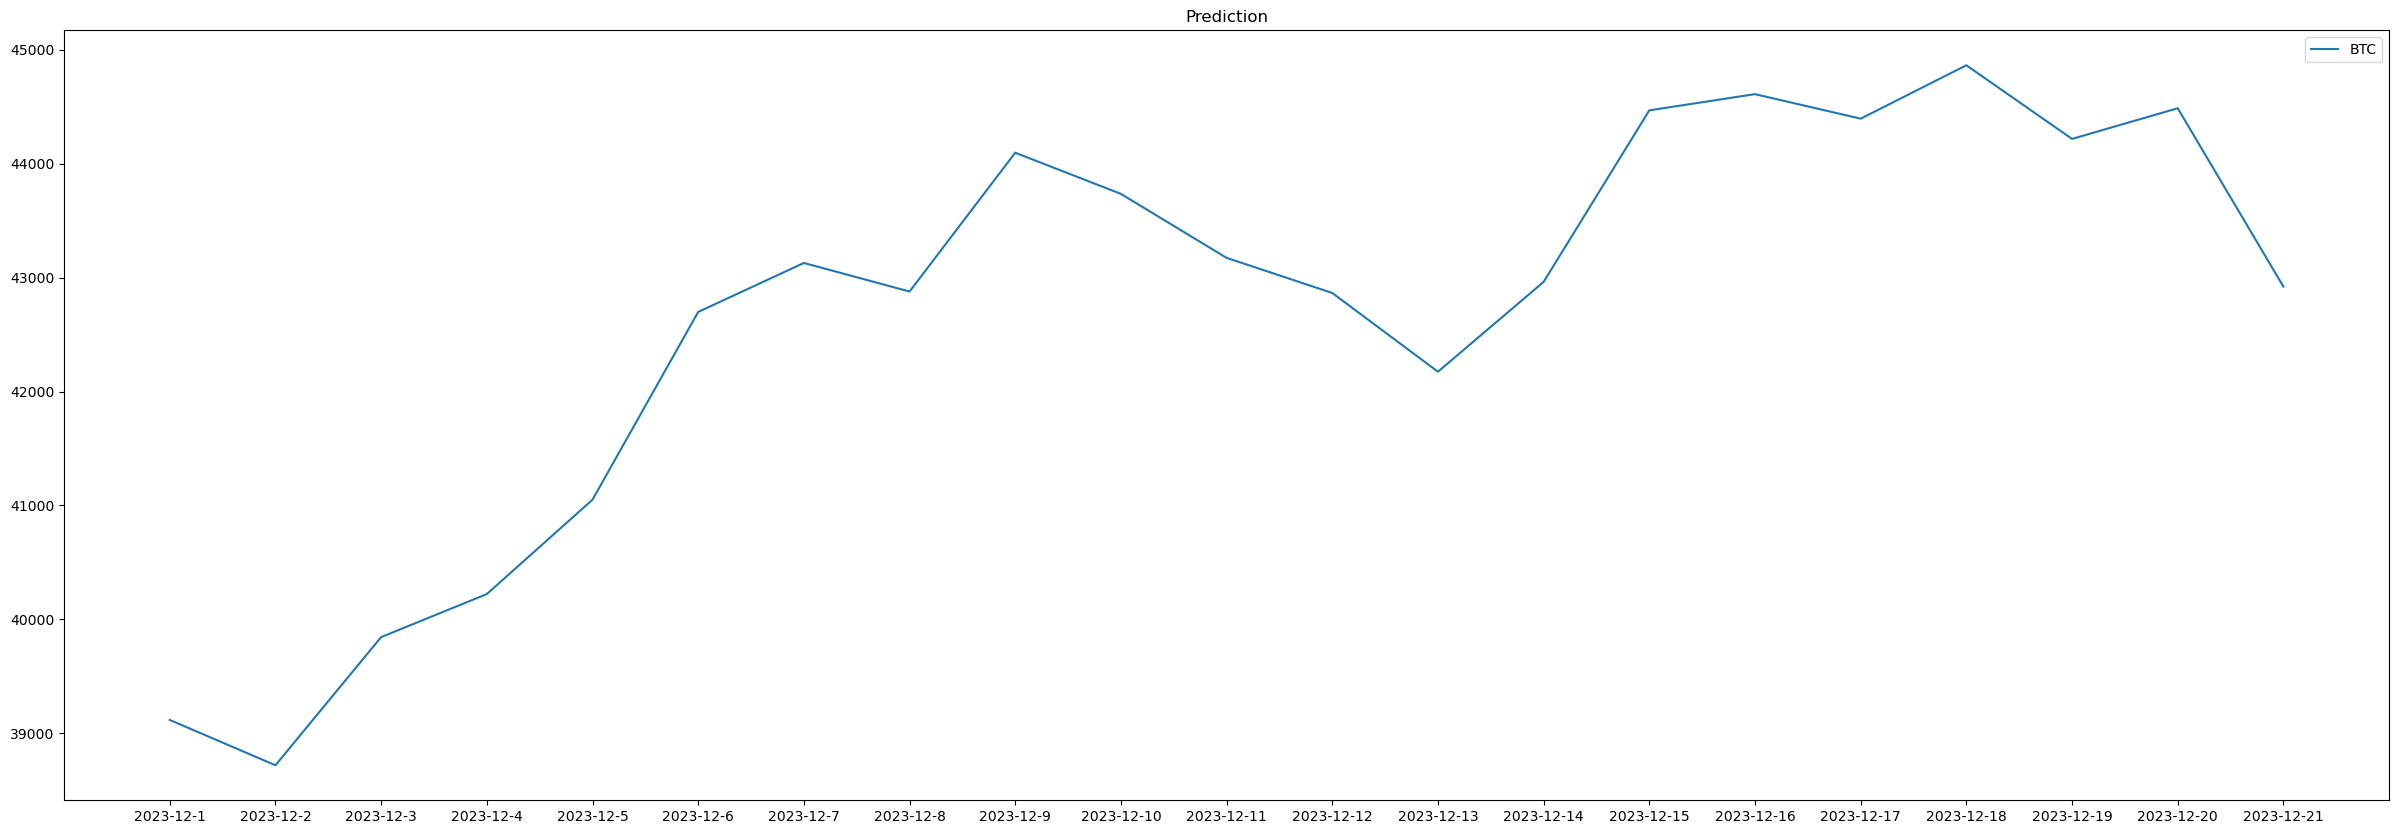

In [23]:
future_predictioins = [future[predict_date] for predict_date in predict_dates]

data_range = predict_dates
plt.figure(figsize=(30, 10))

plt.plot(data_range, future_predictioins, label='BTC')
plt.legend(loc='upper right')
plt.title('Prediction')
plt.savefig('prediction.png')

plt.show()

In [215]:
low = future["2023-12-2"]
high = future["2023-12-9"]
gain = (high - low)/low
invest = 50
print(invest*gain)

6.946726504257004
